In [5]:
from splitters import k_fold_edge_split, train_test_split_edges
from dataset_loader import load_dataframes
from model import Net
from utils import train_model, device_finder, train_model_on_folds, predict_edges, plot_layers_curve
import warnings
from graph_data_creater import create_graph_data_with_different_features
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch_geometric.transforms import LocalDegreeProfile
import torch
from torch_geometric.data import Data
import numpy as np
# plotting shapes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# ignoring warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

final_dt_df, final_w2v_df, final_nv_df, final_fin_df, final_in_df, final_se_df, all_df = load_dataframes()
data_list = [data_dt, data_w2v, data_n2v, data_fin, data_in, data_se] = create_graph_data_with_different_features()

Epoch: 100, Train Loss: 0.448193, Val Auc: 0.924842, Test Auc: 0.924119


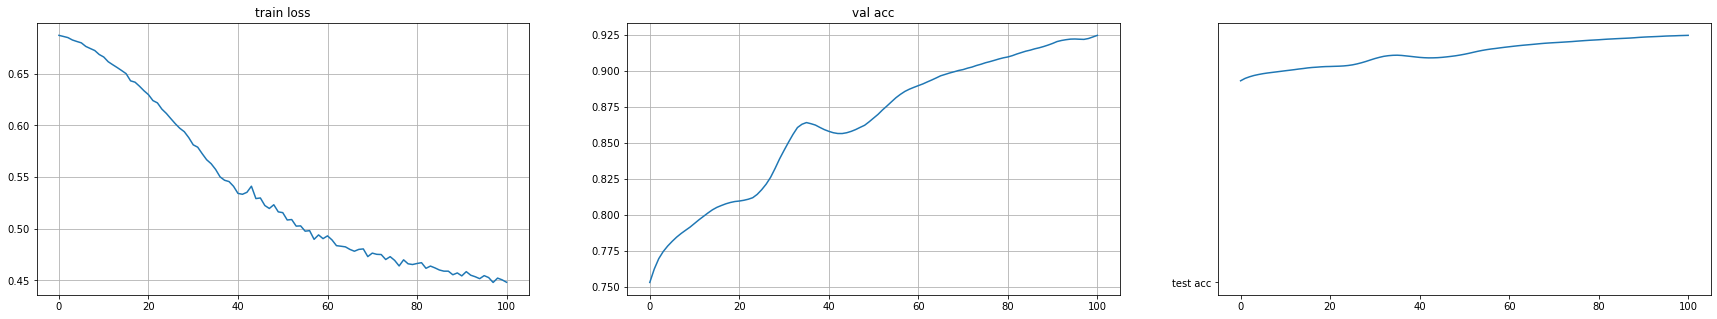

Epoch: 100, Train Loss: 0.508177, Val Auc: 0.852031, Test Auc: 0.855668


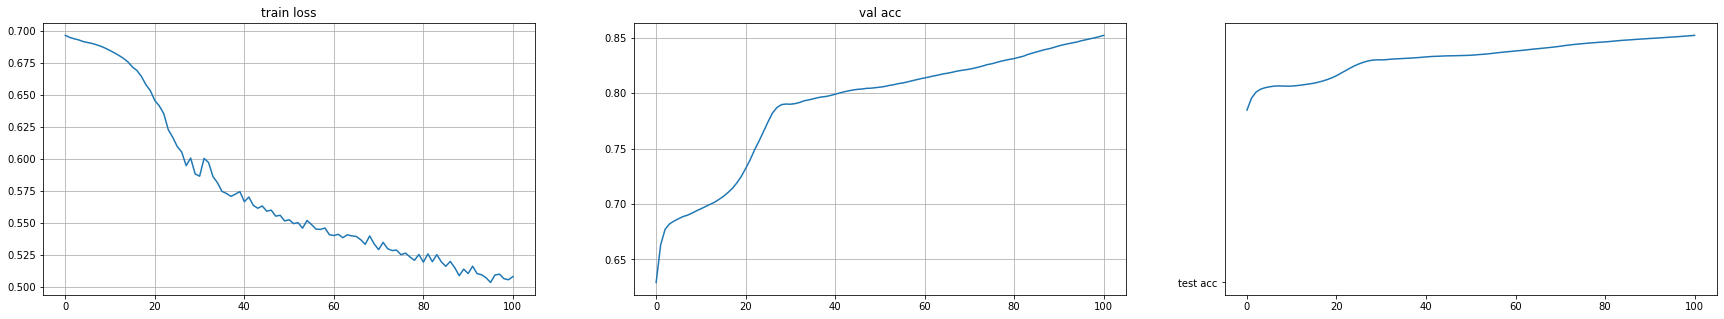

Epoch: 100, Train Loss: 0.587671, Val Auc: 0.796293, Test Auc: 0.774867


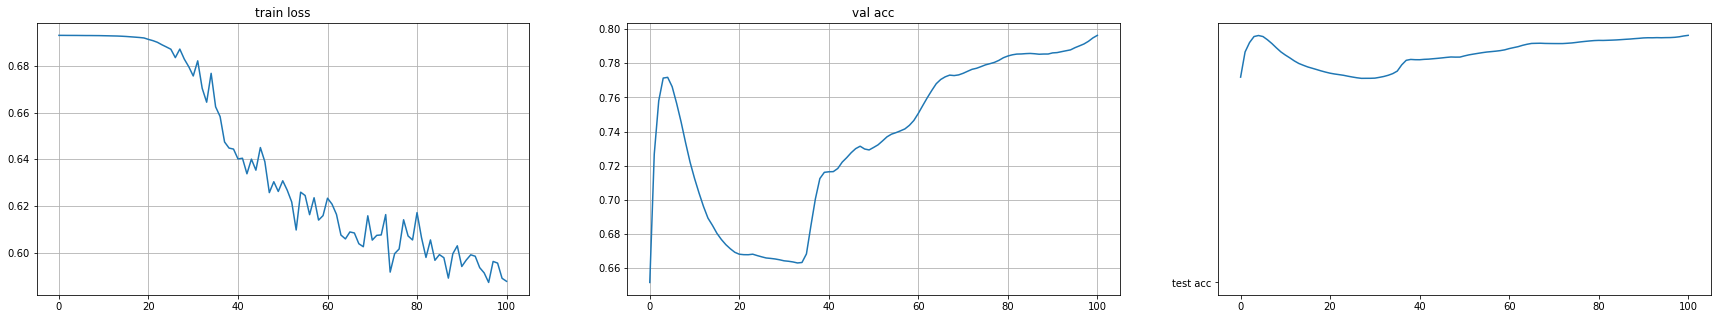

Epoch: 100, Train Loss: 0.476454, Val Auc: 0.893449, Test Auc: 0.895141


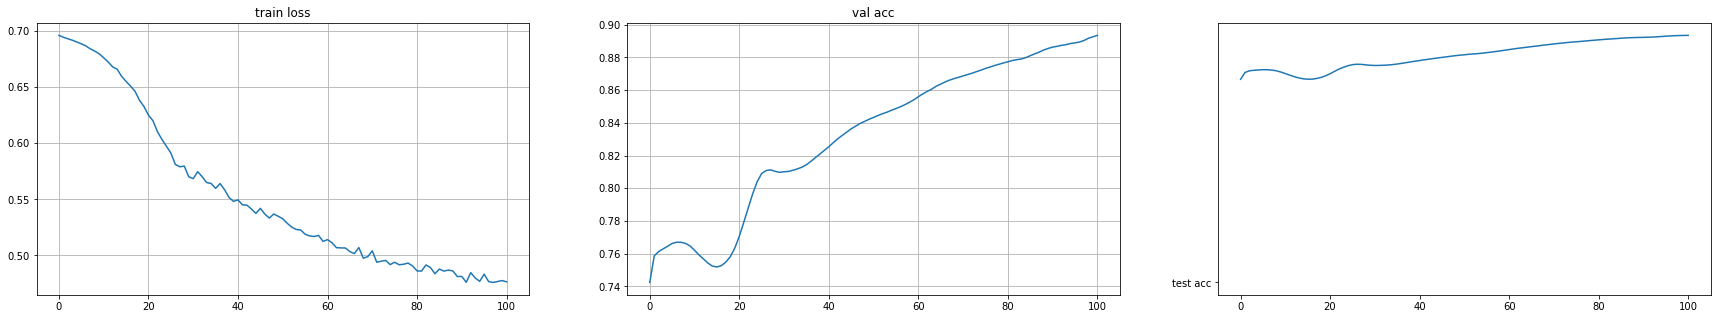

Epoch: 100, Train Loss: 0.564157, Val Auc: 0.819896, Test Auc: 0.802580


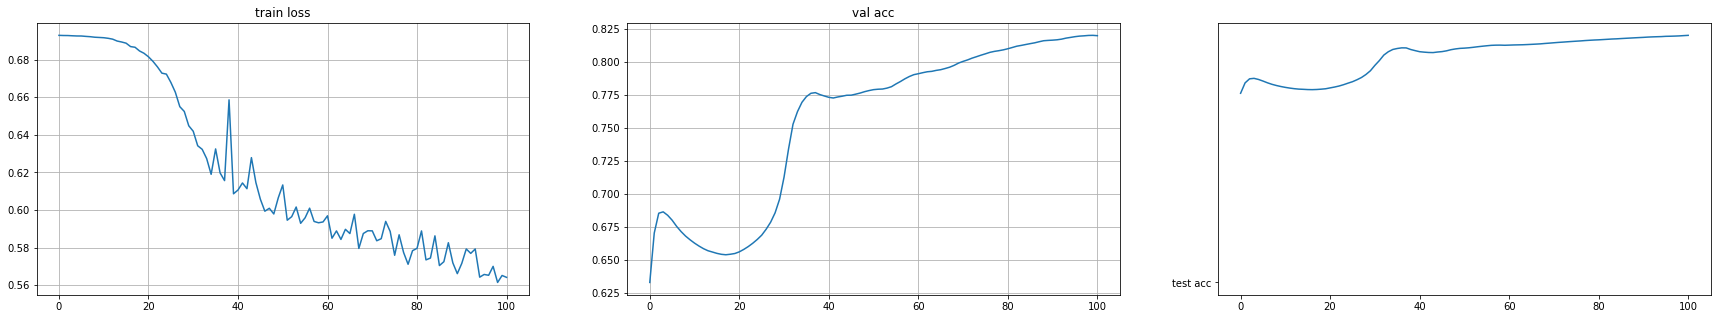

Epoch: 100, Train Loss: 0.490239, Val Auc: 0.876807, Test Auc: 0.861451


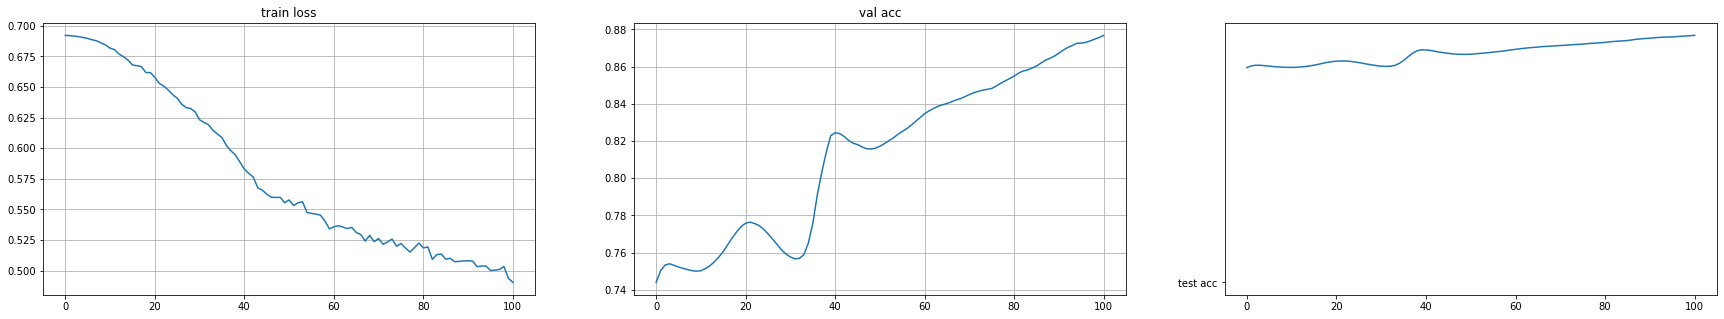

Epoch: 100, Train Loss: 0.531154, Val Auc: 0.941596, Test Auc: 0.946236


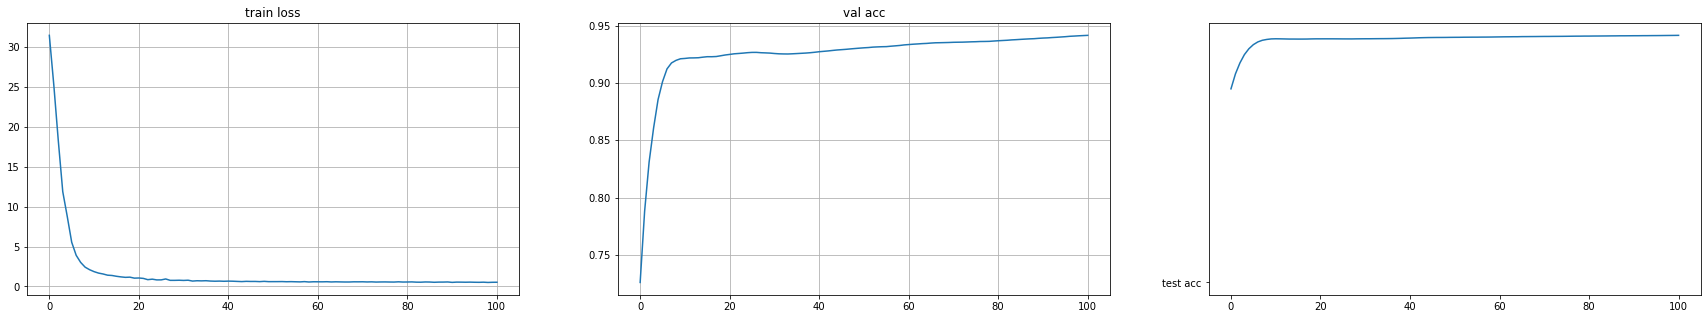

Epoch: 100, Train Loss: 0.505983, Val Auc: 0.905539, Test Auc: 0.914495


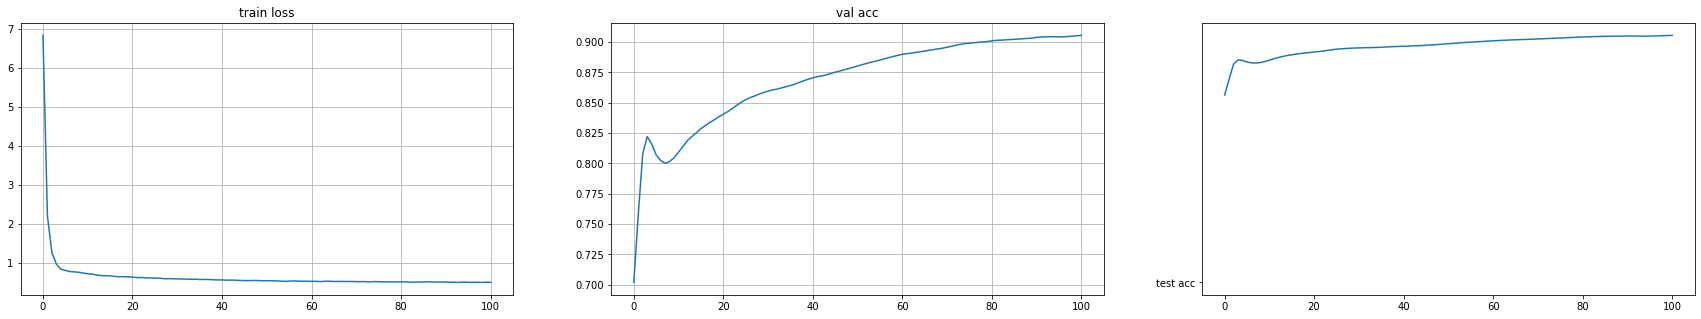

Epoch: 100, Train Loss: 0.558264, Val Auc: 0.878832, Test Auc: 0.856785


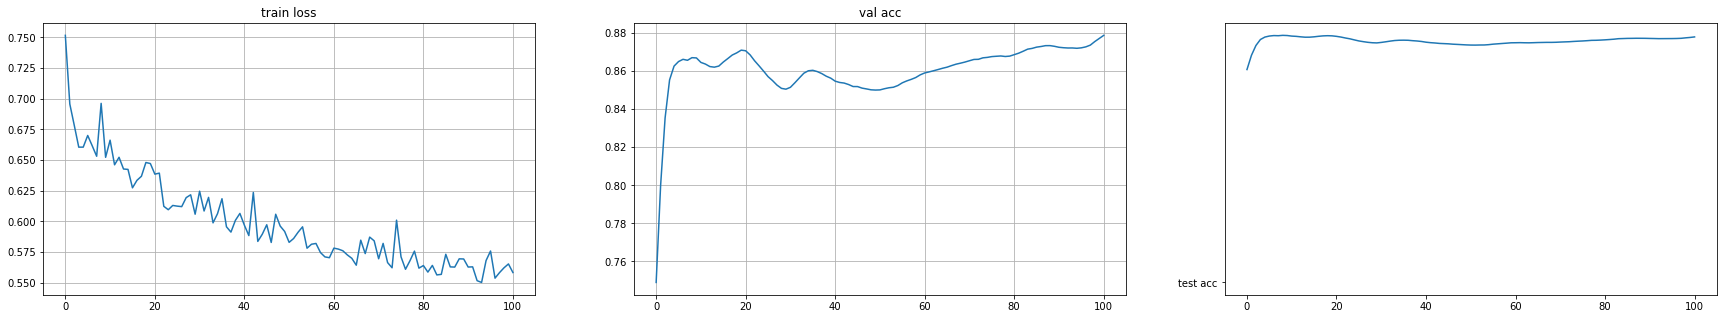

Epoch: 100, Train Loss: 0.489536, Val Auc: 0.934173, Test Auc: 0.936010


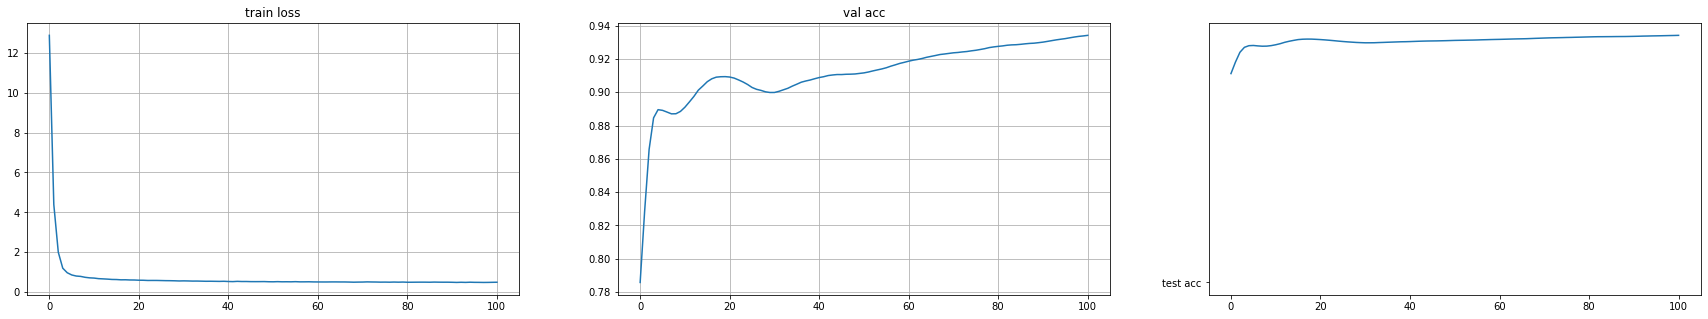

Epoch: 100, Train Loss: 0.519715, Val Auc: 0.905017, Test Auc: 0.904686


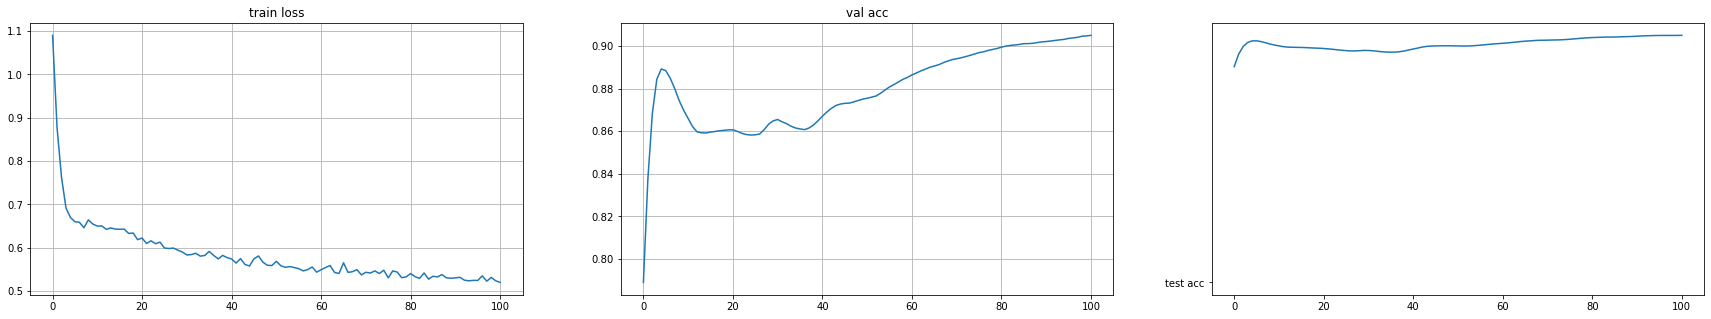

Epoch: 100, Train Loss: 0.487015, Val Auc: 0.940875, Test Auc: 0.934920


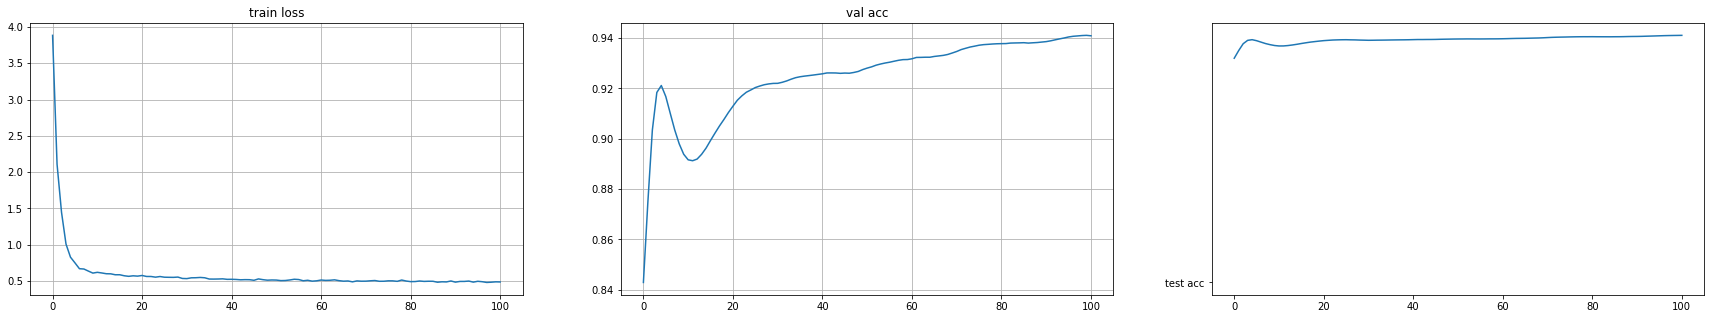

Epoch: 100, Train Loss: 0.435920, Val Auc: 0.974798, Test Auc: 0.973282


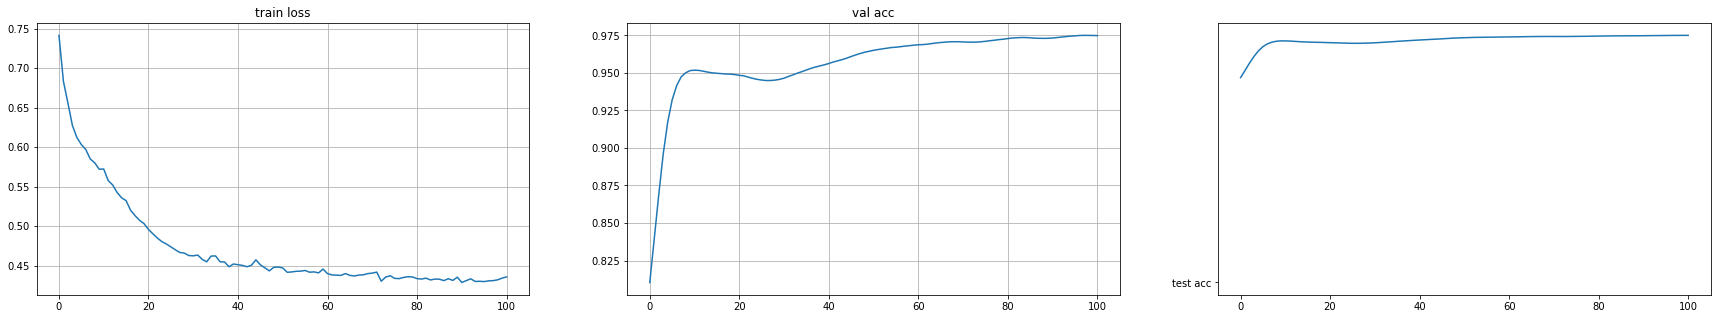

Epoch: 100, Train Loss: 0.463419, Val Auc: 0.932810, Test Auc: 0.935325


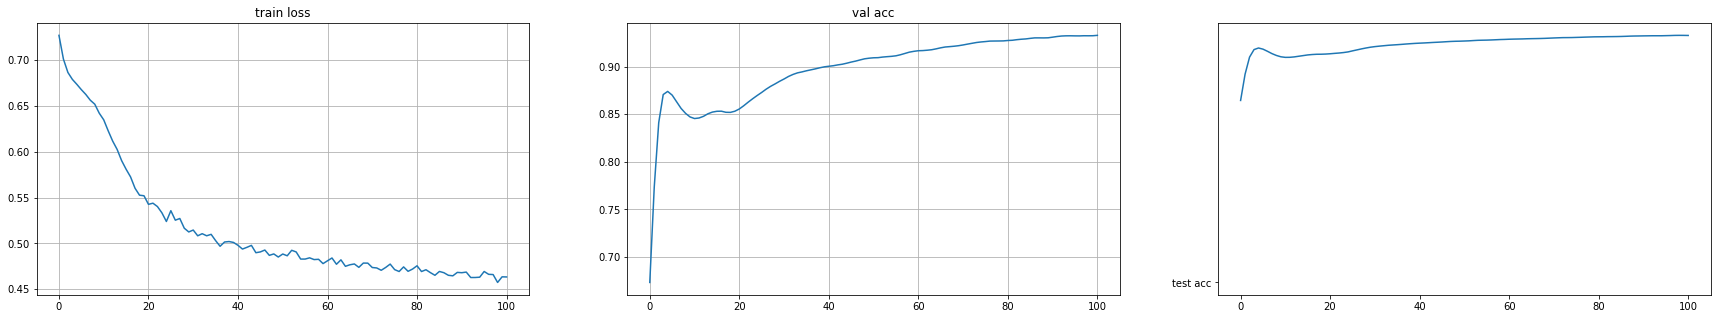

Epoch: 100, Train Loss: 0.557330, Val Auc: 0.898567, Test Auc: 0.887289


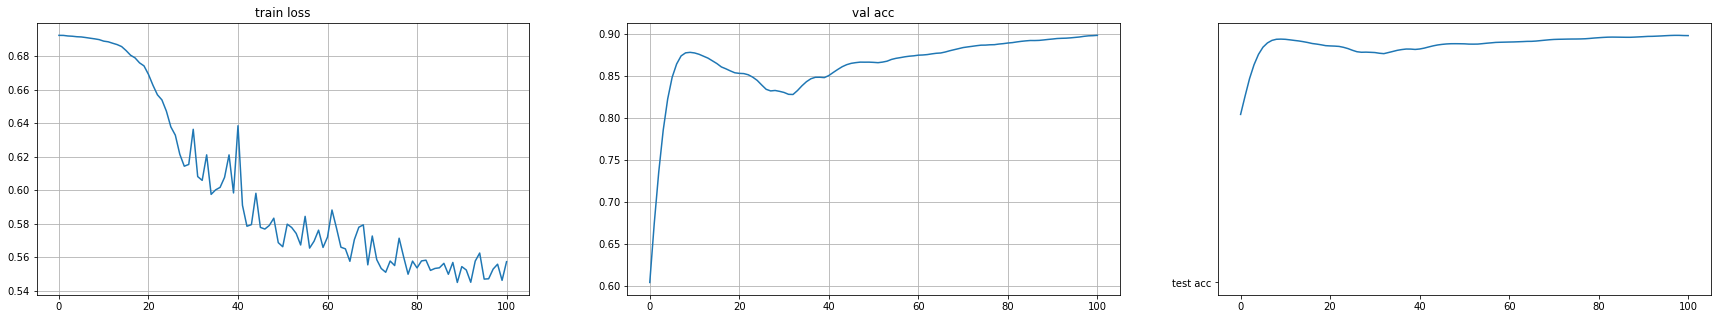

Epoch: 100, Train Loss: 0.441542, Val Auc: 0.956035, Test Auc: 0.963090


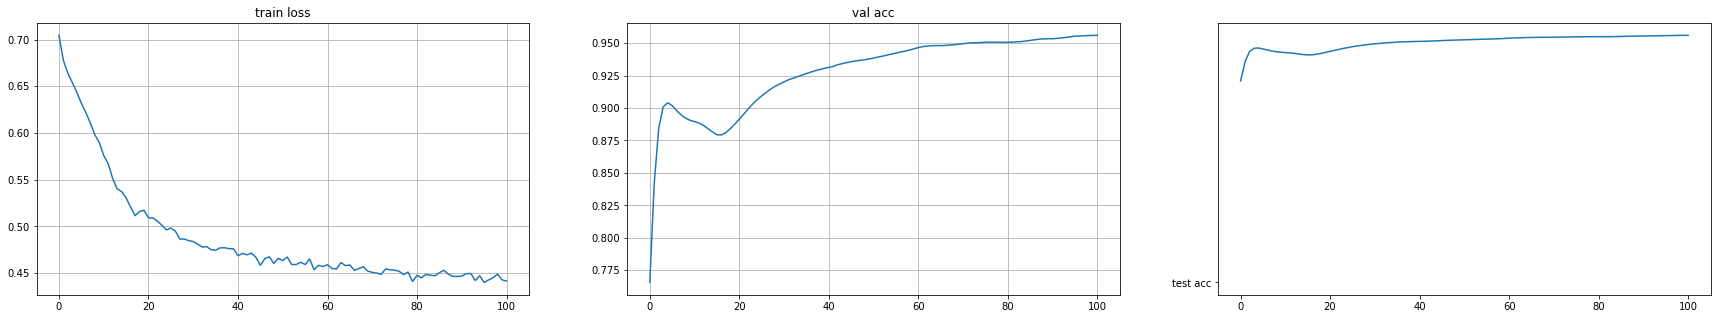

Epoch: 100, Train Loss: 0.508977, Val Auc: 0.908116, Test Auc: 0.907424


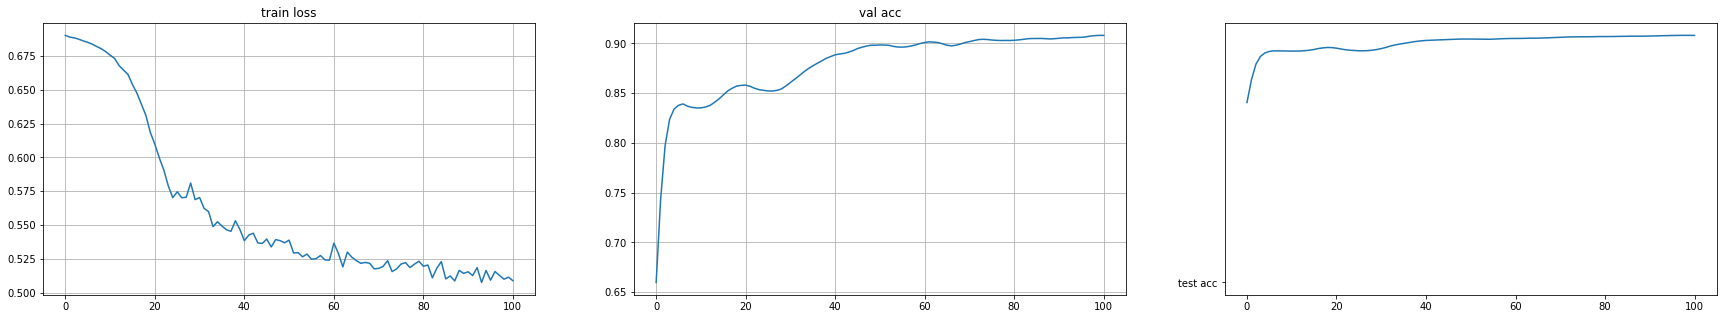

Epoch: 100, Train Loss: 0.445370, Val Auc: 0.965986, Test Auc: 0.964993


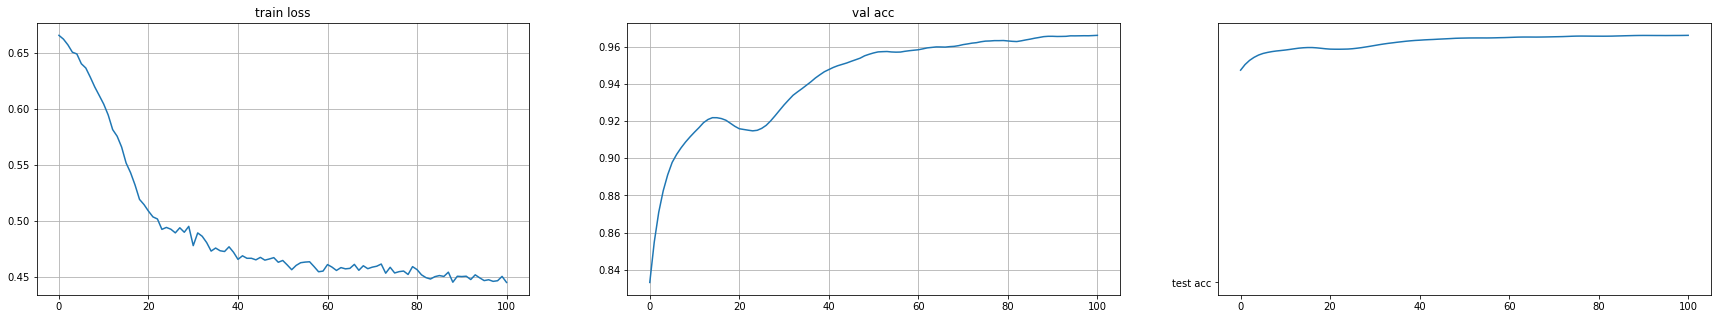

Epoch: 100, Train Loss: 0.504552, Val Auc: 0.891757, Test Auc: 0.894376


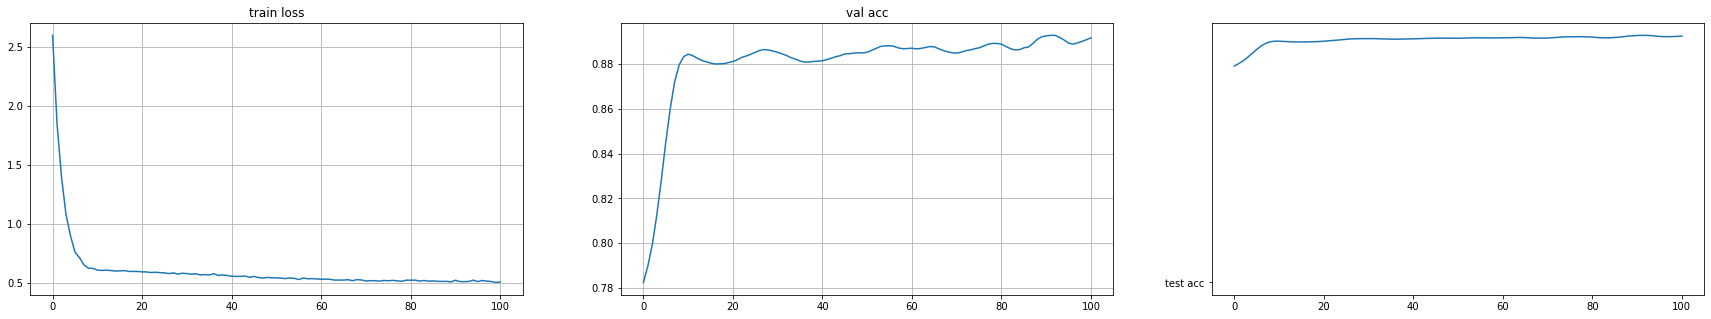

Epoch: 100, Train Loss: 0.513979, Val Auc: 0.856262, Test Auc: 0.854818


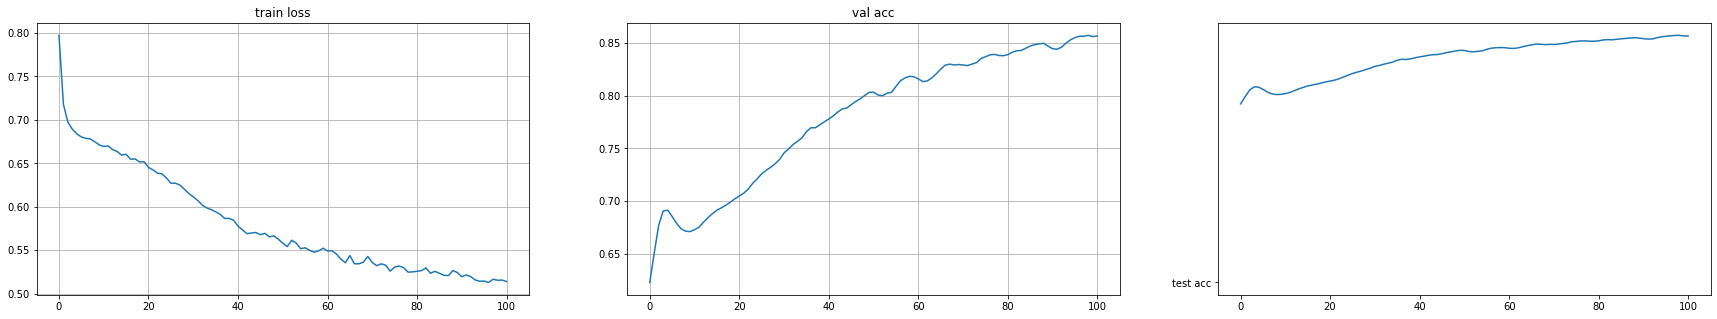

Epoch: 100, Train Loss: 0.589765, Val Auc: 0.759660, Test Auc: 0.777008


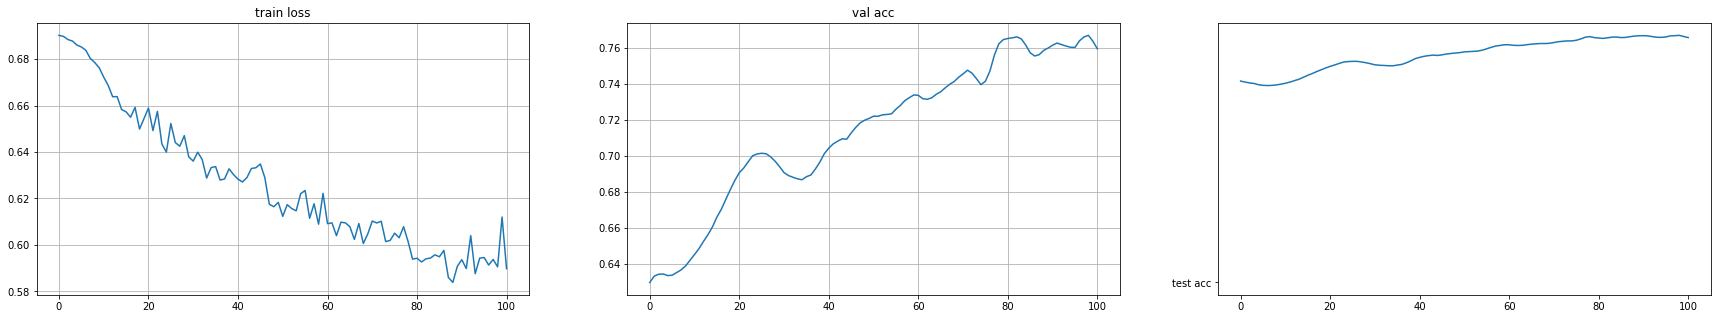

Epoch: 100, Train Loss: 0.499834, Val Auc: 0.873367, Test Auc: 0.871797


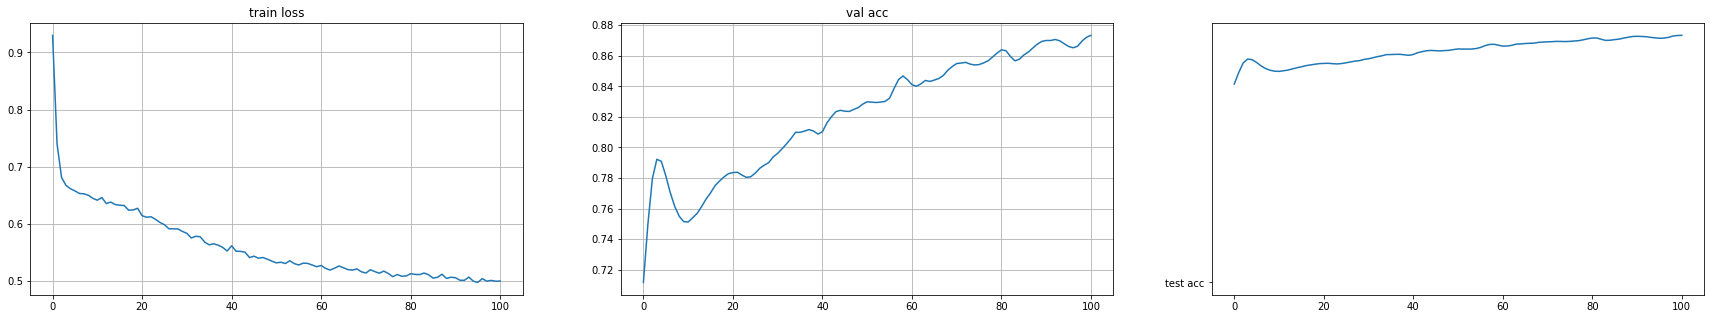

Epoch: 100, Train Loss: 0.579985, Val Auc: 0.785555, Test Auc: 0.784203


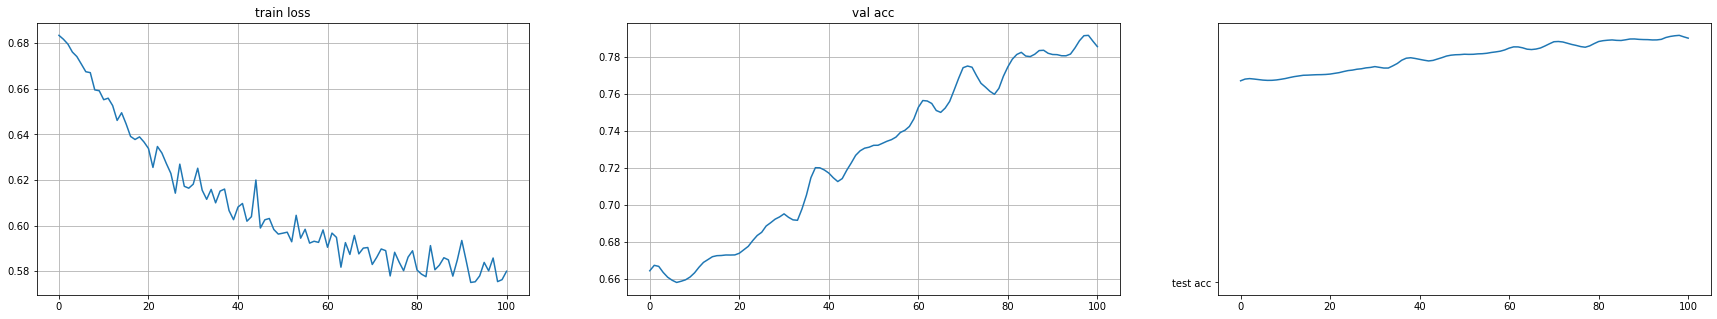

Epoch: 100, Train Loss: 0.503958, Val Auc: 0.851837, Test Auc: 0.843011


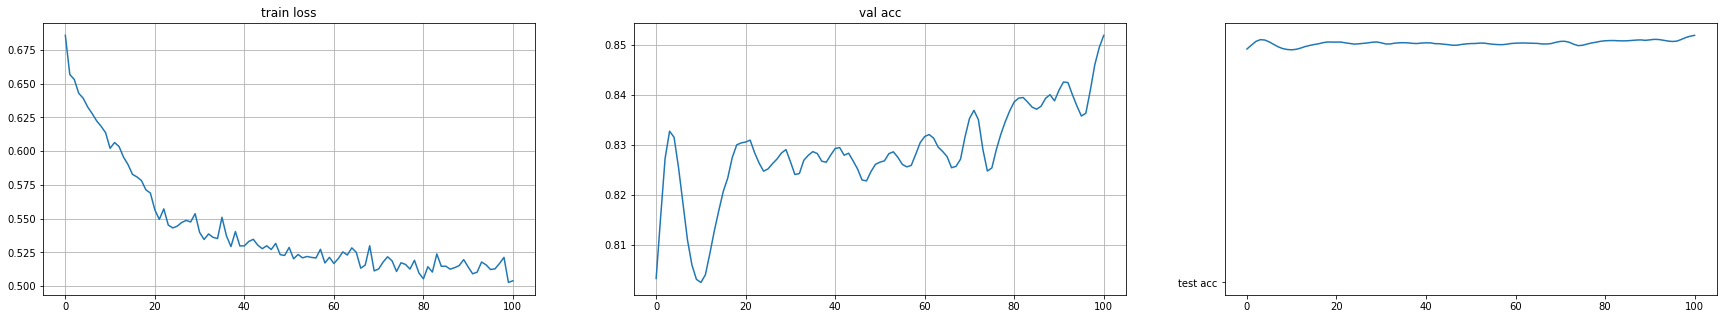

Epoch: 100, Train Loss: 0.411656, Val Auc: 0.952073, Test Auc: 0.944946


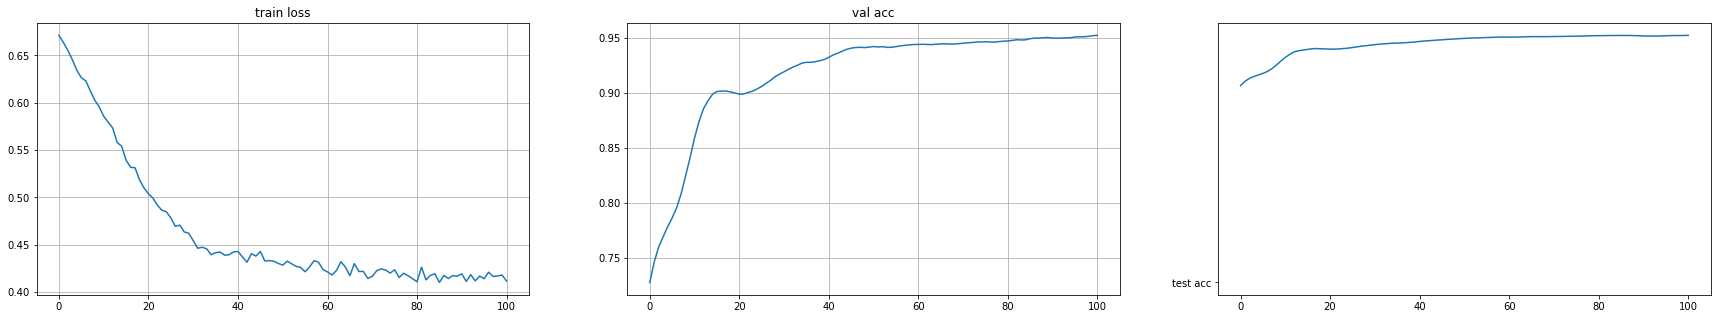

Epoch: 100, Train Loss: 0.440039, Val Auc: 0.913425, Test Auc: 0.897353


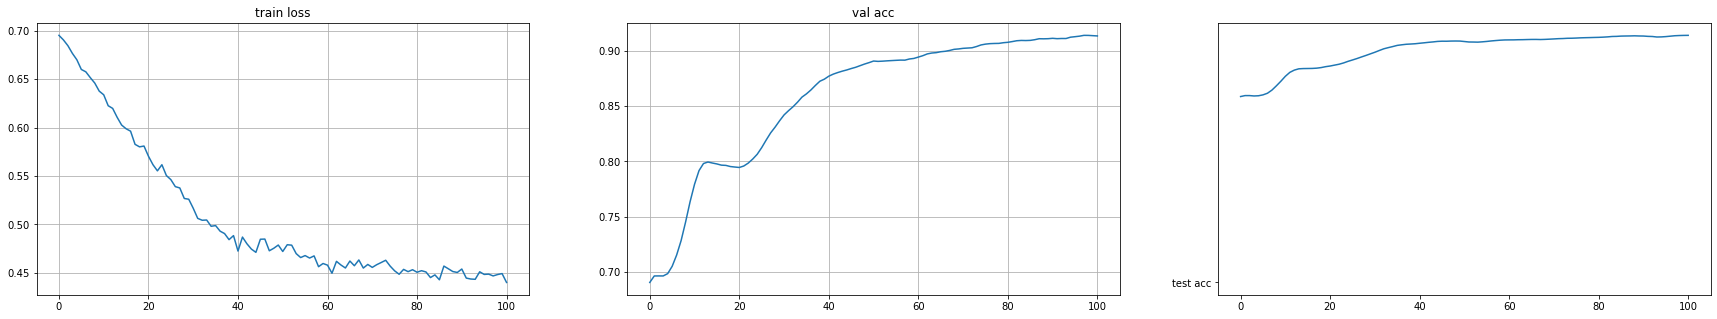

Epoch: 100, Train Loss: 0.576309, Val Auc: 0.737851, Test Auc: 0.712978


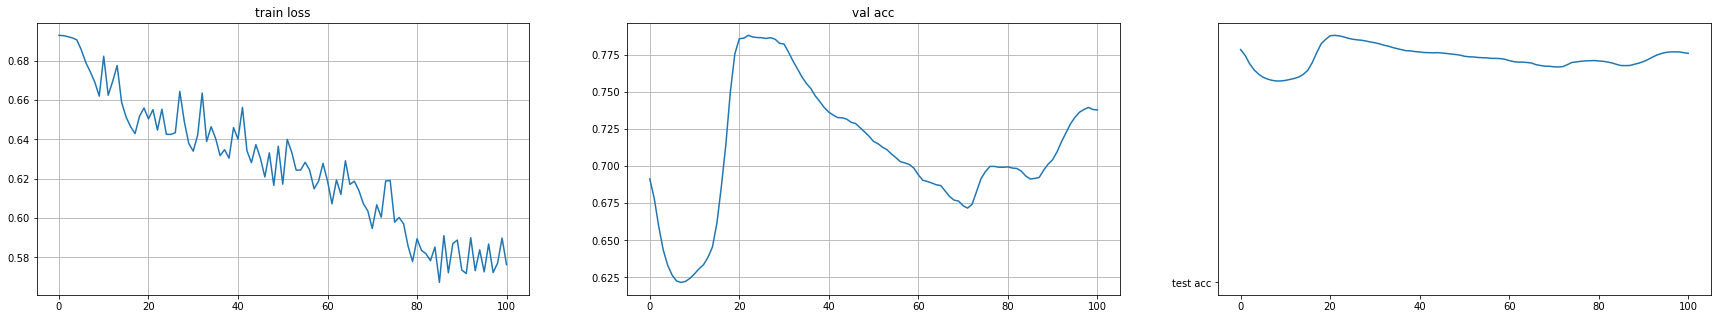

Epoch: 100, Train Loss: 0.436915, Val Auc: 0.943335, Test Auc: 0.927057


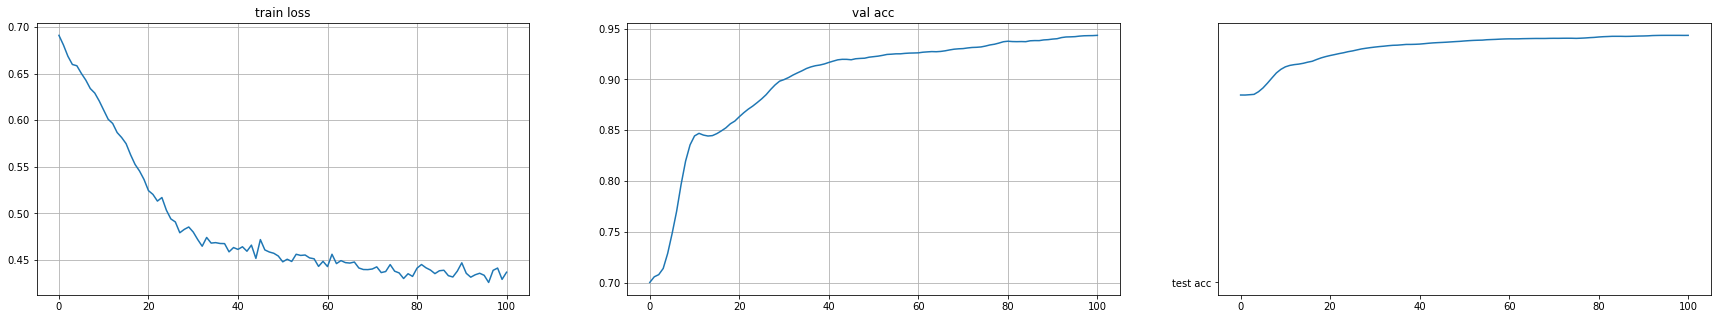

Epoch: 100, Train Loss: 0.551992, Val Auc: 0.855070, Test Auc: 0.830373


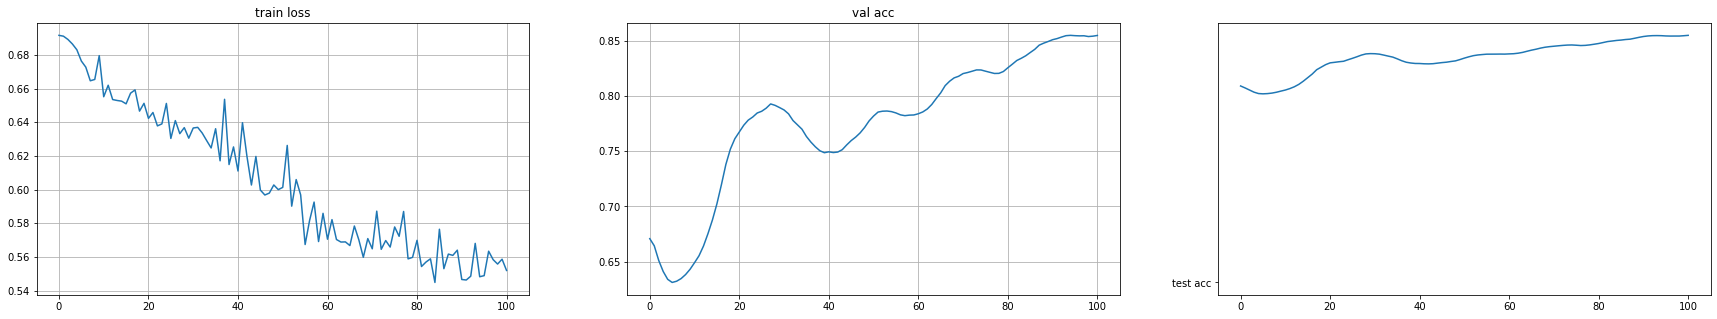

Epoch: 100, Train Loss: 0.439651, Val Auc: 0.937580, Test Auc: 0.917235


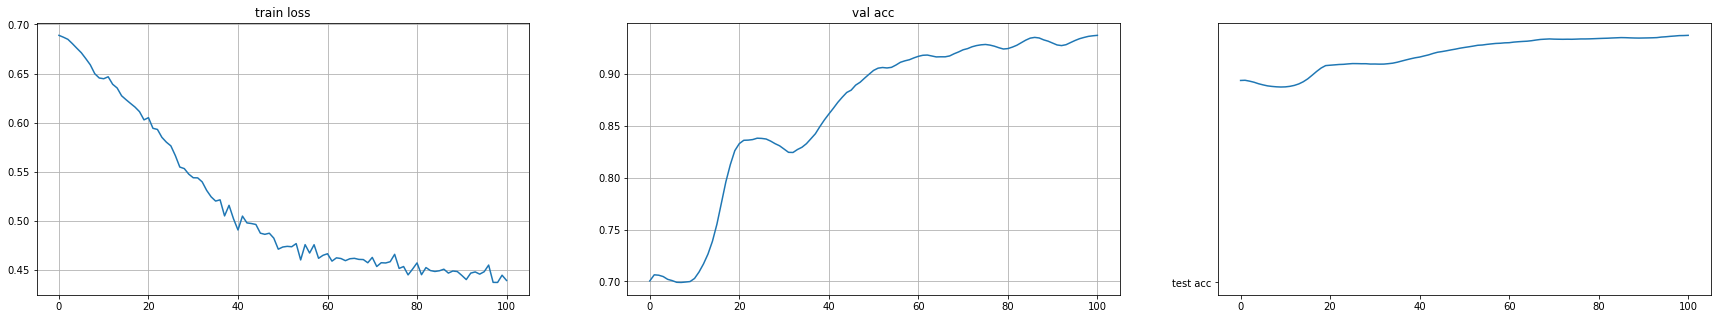

Epoch: 100, Train Loss: 0.427025, Val Auc: 0.952635, Test Auc: 0.942689


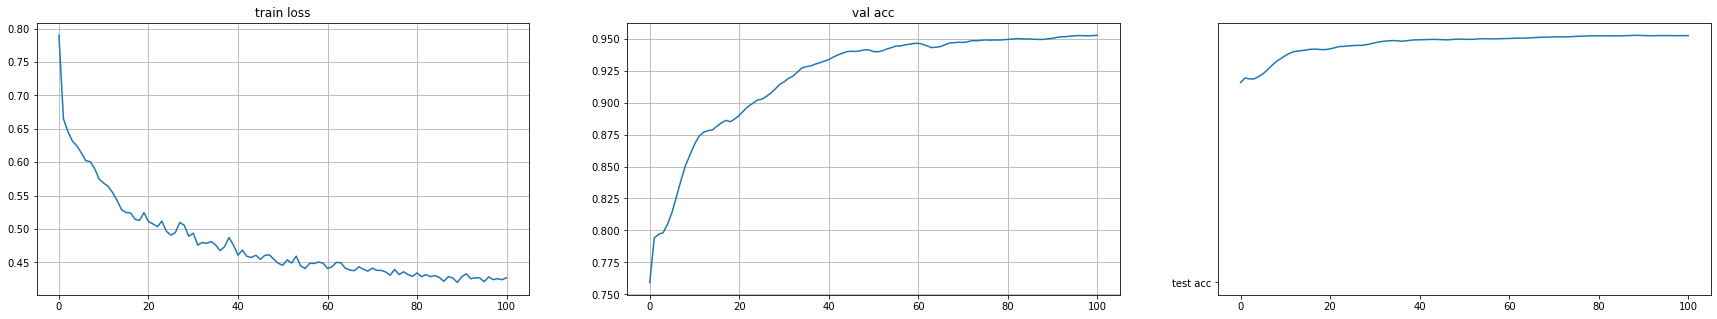

Epoch: 100, Train Loss: 0.448211, Val Auc: 0.922140, Test Auc: 0.914700


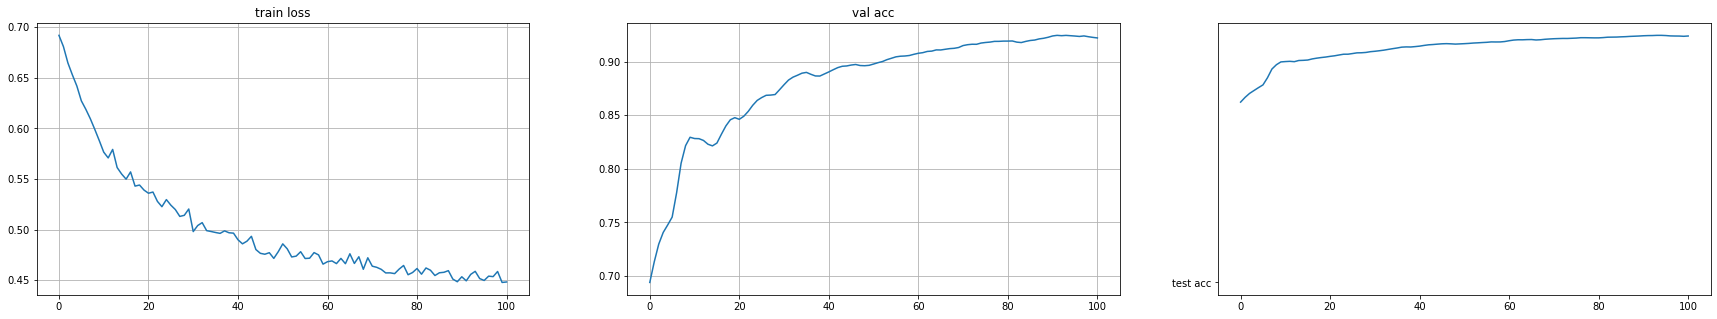

Epoch: 100, Train Loss: 0.597483, Val Auc: 0.812295, Test Auc: 0.803274


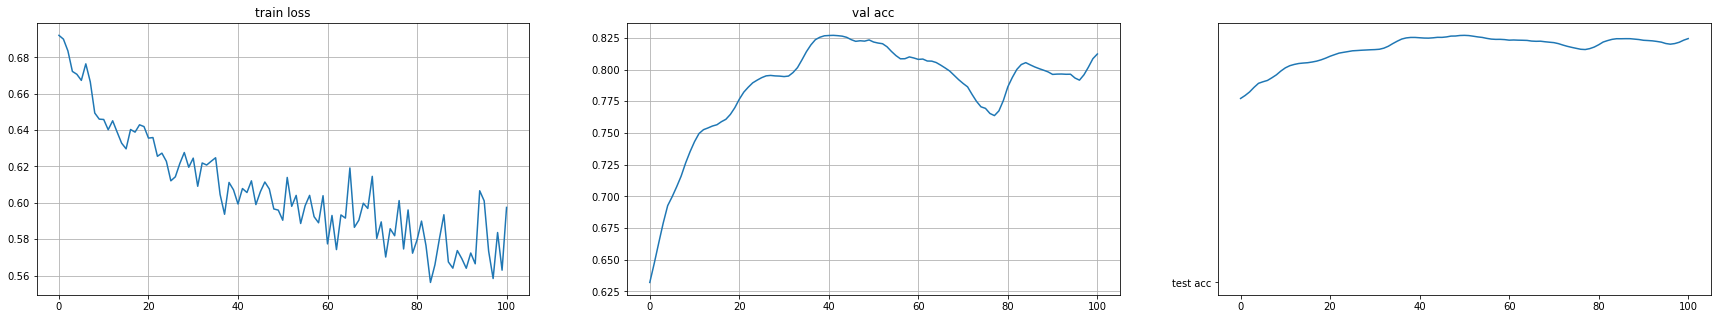

Epoch: 100, Train Loss: 0.436179, Val Auc: 0.946777, Test Auc: 0.932555


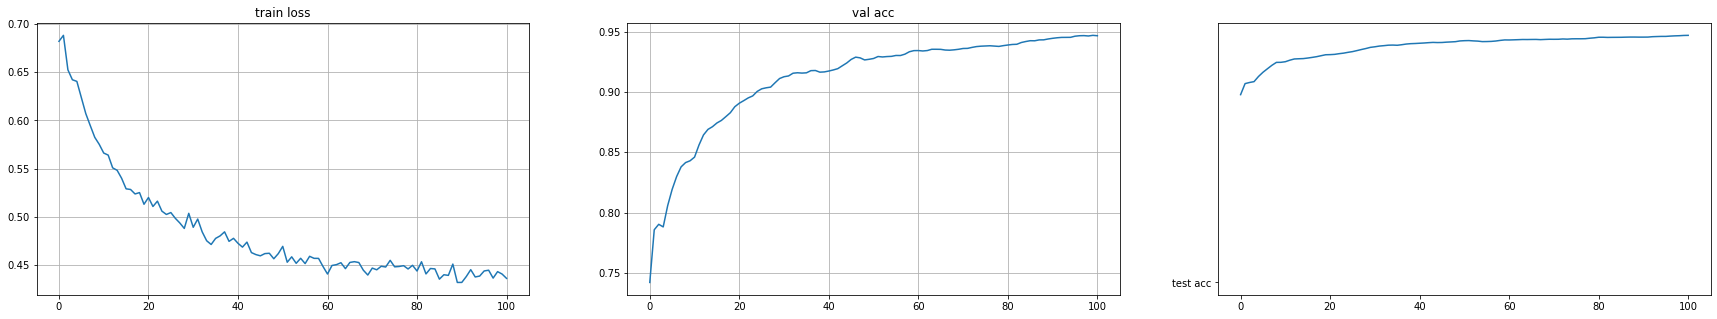

Epoch: 100, Train Loss: 0.544609, Val Auc: 0.861054, Test Auc: 0.857201


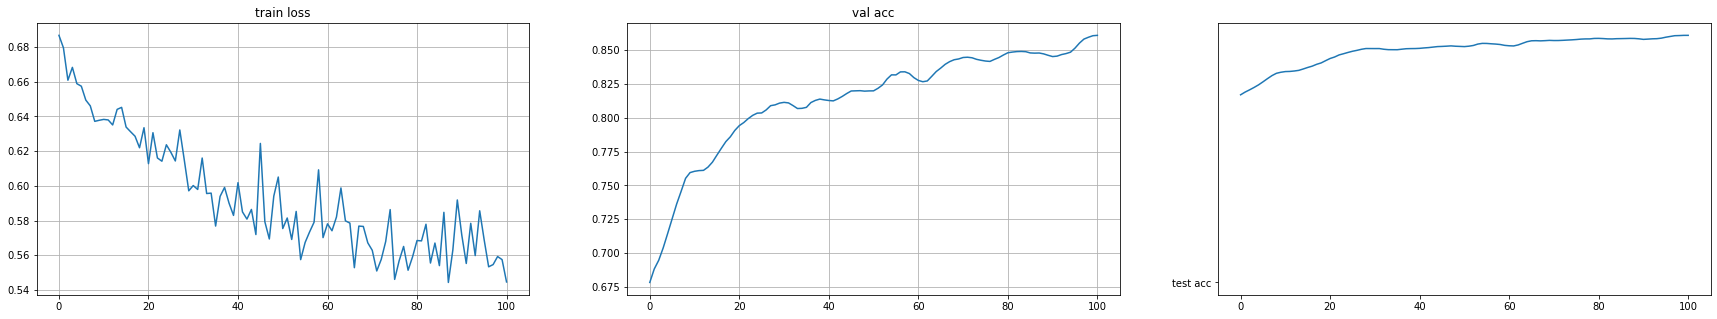

Epoch: 100, Train Loss: 0.455880, Val Auc: 0.917785, Test Auc: 0.907761


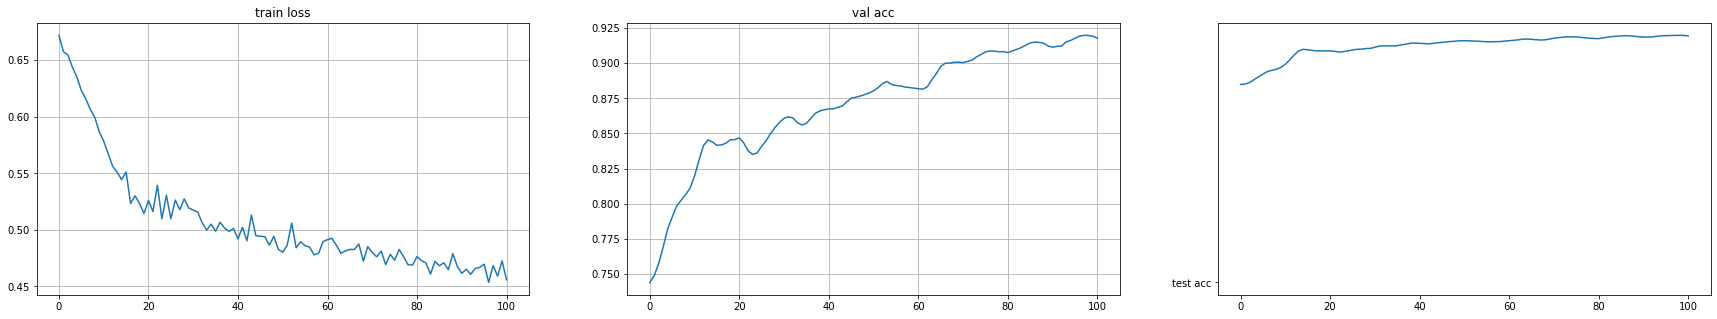

In [19]:
device = device_finder()
# number of channels
hid_channels = 128
out_channels = 64

all_t_list = []
all_v_list = []
all_te_list = []

for data in data_list:
    # creating folds
    folds = k_fold_edge_split(data, only_upper_triangular_portion=False)
    in_channels = folds[0].num_features

    t_list = []
    v_list = []
    te_list = []

    for index in range(0, 6):
        train_loss, val_auc, test_auc, model, val_aupr, test_aupr, val_fscore, test_fscore = train_model_on_folds(folds=folds,
                                    num_epochs=101, index=index, in_channels=in_channels, hid_channels=hid_channels, 
                                    out_channels=out_channels, device=device, model_class=Net, lr=0.0005, verbose=0)
        t_list.append(train_loss[99])
        v_list.append(val_auc[99])
        te_list.append(test_auc[99])
    
    all_t_list.append(t_list)
    all_v_list.append(v_list)
    all_te_list.append(te_list)

In [51]:
def plotter(scores, method_names, colors):
    # method_names = ['GTB [2019]', 'AuDNNsynergy [2021]', 'DComG']
    # scores = [0.949, 0.925, roc_auc_score]

    plt.figure(figsize=(28, 6))

    d = {'models': method_names, 'values': scores}
    df = pd.DataFrame(d, columns=['models', 'values'])
    plots = sns.barplot(x='models', y='values', data=df, color='gray')

    width = 0.4

    plt.title('AUC Test Score')
    for i, bar in enumerate(plots.patches):
        plots.annotate(format(bar.get_height(), '.3f'),
        (bar.get_x() + bar.get_width() / 2,
        bar.get_height()), ha='center', va='center', 
        size=15, xytext=(-12, 10),
        textcoords='offset points')
        bar.set_width(width)
        bar.set_color(colors[int(i / 6)])
    
    for item in plots.get_xticklabels():
        item.set_rotation(45)

    plt.ylim(0.7, 0.99)
    plt.grid()
    plt.show()

             dt      w2v     n2v     fin     ind     se  
GCN         0.924   0.854   0.773   0.895   0.802   0.860
SAGE        0.946   0.914   0.855   0.936   0.904   0.935
GAT         0.973   0.936   0.888   0.963   0.908   0.965
SAGE-GCN    0.894   0.855   0.780   0.871   0.788   0.840
GAT-SAGE    0.944   0.897   0.715   0.927   0.829   0.917
GCN-GAT     0.942   0.914   0.798   0.932   0.857   0.909



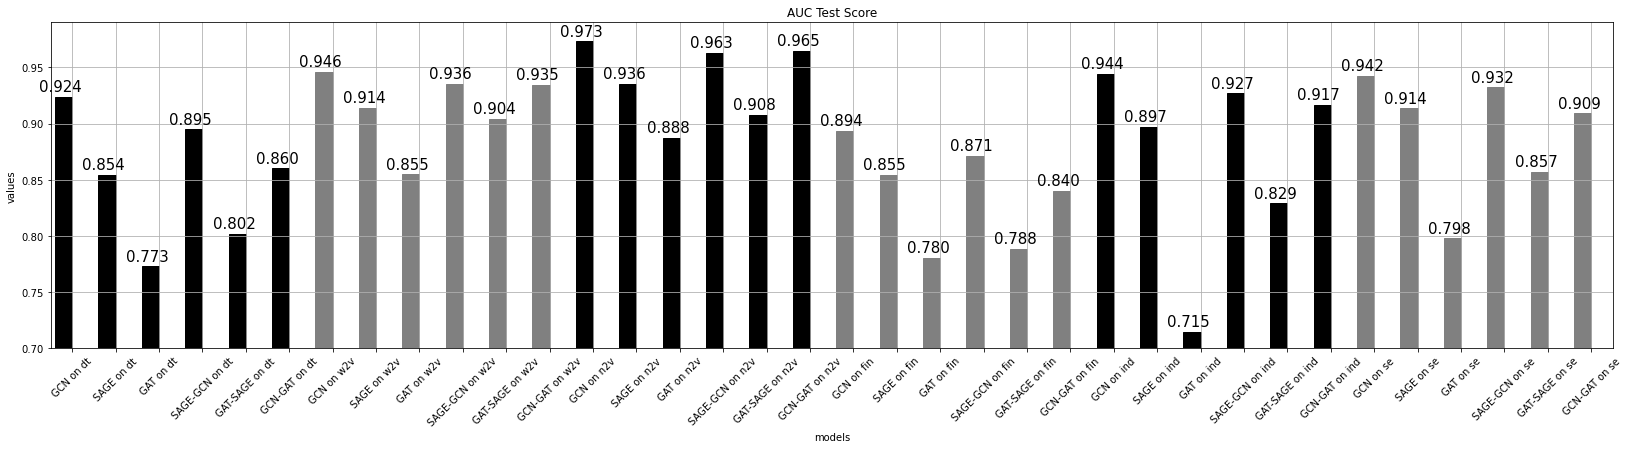

In [106]:
model_names = ['GCN', 'SAGE', 'GAT', 'SAGE-GCN', 'GAT-SAGE', 'GCN-GAT']
feature_names = ['dt', 'w2v', 'n2v', 'fin', 'ind', 'se']
colors = ['black', 'gray', 'black', 'gray', 'black', 'gray']
method_names = []
all_test = []
print(' '* 13, end='')
for i, name in enumerate(feature_names):
    if i % 6 != 5:
        print(f'{name:<7}', end=' ')
    else:
        print(f'{name:<4}', end='')
print()
for i, model in enumerate(feature_names):
    print(f'{model_names[i]:<10}', end='  ')
    for j, feature in enumerate(model_names):
        if j % 6 != 5:
            print(format(all_te_list[i][j], '.3f'), end='   ')
        else:
            print(format(all_te_list[i][j], '.3f'), end='')
        method_names.append(f'{feature} on {model}')
        all_test.append(all_te_list[i][j])
    if i % 6 == 5:
        print('')
    print()

plotter(all_test, method_names, colors)

In [ ]:
folds = k_fold_edge_split(data_n2v, only_upper_triangular_portion=False)

device = device_finder()

in_channels = folds[0].num_features
hid_channels = 128
out_channels = 64

t_list = []
v_list = []
te_list = []

for index in range(0, 6):
    train_loss, val_acc, test_acc, model, val_aupr, test_aupr, val_fscore, test_fscore = train_model_on_folds(folds=folds, num_epochs=101, index=index, in_channels=in_channels, hid_channels=hid_channels, out_channels=out_channels, device=device, model_class=Net, lr=0.0005, verbose=0)
    t_list.append(train_loss)
    v_list.append(val_acc)
    te_list.append(test_acc)